## Libraries

In [14]:
from torch import Tensor
import torch
import torch.nn as nn
import pandas as pd

from tqdm import tqdm

from utils.vocabulary import Vocabulary
from utils.smartdataloader import SmartDataLoader
from timeit import default_timer as timer
import math
import matplotlib.pyplot as plt
import os
import pickle
from transformers import get_linear_schedule_with_warmup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## Read Data

In [2]:
data = pd.read_csv('./deu.txt', delimiter='\t', header=None)
data.columns= ['eng', 'ger', 'cc']
data = data.iloc[:100000, :]

print(data.shape)

(100000, 3)


## Create Vocabulary


In [3]:
eng_vocab = Vocabulary(data['eng'].to_list())
ger_vocab = Vocabulary(data['ger'].to_list())

### Dump vocabulary to save recalculation 

In [4]:
with open('eng_vocab.pkl', 'wb') as f:
    pickle.dump(eng_vocab, f)

with open('ger_vocab.pkl', 'wb') as f:
    pickle.dump(ger_vocab, f)


### Open dumped vocabulary

In [15]:
with open('eng_vocab.pkl', 'rb') as f:
    eng_vocab: Vocabulary = pickle.load(f)

with open('ger_vocab.pkl', 'rb') as f:
    ger_vocab : Vocabulary= pickle.load(f)


## Train, Validate, Test Split

In [16]:
eng_docs = eng_vocab.docs_tokens_encoded
ger_docs = ger_vocab.docs_tokens_encoded

leng = len(eng_docs)

train_end_idx = int(leng * 0.8)
valid_end_idx = int(leng * (0.8 + 0.1))
eng_train = eng_docs[:train_end_idx]
eng_valid = eng_docs[train_end_idx:valid_end_idx]
eng_test = eng_docs[valid_end_idx:]

ger_train = ger_docs[:train_end_idx]
ger_valid = ger_docs[train_end_idx:valid_end_idx]
ger_test = ger_docs[valid_end_idx:]

print(f"Train: {len(eng_train)}\nValidation: {len(eng_valid)}\nTest: {len(eng_test)}\n")


Train: 80000
Validation: 10000
Test: 10000



## Model

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)

        # Register buffer that should not be considered as model param
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class MachineTranslation(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        
        super(MachineTranslation, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Masks

In [18]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

PAD_IDX = eng_vocab.PAD_TOKEN

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Training Functions

In [19]:
def train_epoch(model, optimizer, criterion, train_dataloader, scheduler):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss.backward()


        optimizer.step()
        scheduler.step()

        losses += loss.item()


    return losses / len(list(train_dataloader))


def evaluate(model, criterion, val_dataloader):
    model.eval()
    losses = 0

    for src, tgt in tqdm(val_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()


    return losses / len(list(val_dataloader))

## Helper Functions

In [20]:
def setup_model_save_path(save_folder: str) -> str:
    """Initialize a folder path to store checkpoint informations
    Args:
        save_folder (str): Name of folder to keep checkpoints in 
    Returns:
        str: Path of folder to store checkpoints
    """
    project_base_path = os.getcwd()
    save_path = os.path.join(project_base_path, save_folder)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    
    return save_path


def save_checkpoint(state: dict, save_path: str, model_name: str) -> None:
    print("Saving checkpoint")

    filename = f'{model_name}_{state["epoch"]}.pth.tar'
    state_save_path = os.path.join(save_path, filename)

    torch.save(state, state_save_path)

def load_checkpoint(save_path:str, model_name:str,  epoch:str):
    """Loads checkpoint and returns a state dictionary
    Args:
        save_path (str): Path of folder that contains checkpoints
        epoch (str): Checkpoint epoch to load from
    Returns:
        Dict: State dictionary
    """

    filename = f'{model_name}_{epoch}.pth.tar'
    file_path = os.path.join(save_path, filename)

    state = torch.load(file_path)
    return state


## Checkpoint Params

In [21]:
# Model Save Path
checkpoint_folder_name = 'Saves_MT'
model_name = 'tranformer_pt'
save_path = setup_model_save_path(checkpoint_folder_name)


start_epoch = 0 # No need to change

# Number of epochs to train the model for
num_epochs = 20

# Whether to load previous model or not
load_model = False

# Which epoch to load
load_epoch = 0

# Save checkpoints every x epochs
save_checkpoint_every = 5

## Hyperparameters

In [22]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(eng_vocab.vocab)
TGT_VOCAB_SIZE = len(ger_vocab.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = MachineTranslation(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

train_dataloader = SmartDataLoader(eng_vocab, ger_vocab, BATCH_SIZE, eng_vocab.max_length, ger_vocab.max_length, eng_train, ger_train)
val_dataloader = SmartDataLoader(eng_vocab, ger_vocab, BATCH_SIZE, eng_vocab.max_length, ger_vocab.max_length,  eng_valid, ger_valid)




## Instantiate Model

In [23]:
transformer = transformer.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)

total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(total_steps * 0.1) # 10% of total steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

## Load previous model if required

In [14]:
if load_model:
    start_epoch = load_epoch
    
    # Load state from checkpoint
    state = load_checkpoint(save_path, model_name, load_epoch)

    transformer.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])

    train_loss = state['train_loss']
    val_loss = state['val_loss']
else:    
    train_loss = []
    val_loss = []


## Train

In [15]:


for epoch in range(load_epoch, load_epoch+num_epochs):
    print(f"Epoch: {epoch+1}/{load_epoch+num_epochs}")

    start_time = timer()

    train_epoch_loss = train_epoch(transformer, optimizer, criterion, train_dataloader,scheduler)
    end_time = timer()
    val_epoch_loss = evaluate(transformer, criterion, val_dataloader)

    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    print(f"Train loss: {train_epoch_loss:.3f}, \
          Val loss: {val_epoch_loss:.3f}, \
          Epoch time = {(end_time - start_time):.3f}s")

    
    
    if (epoch+1) % save_checkpoint_every == 0:
        checkpoint = {
            'state_dict': transformer.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epoch': epoch+1
        }
        save_checkpoint(checkpoint, save_path, 'tranformer_pt')






Epoch: 1/20


100%|██████████| 19/19 [00:02<00:00,  6.37it/s]


Train loss: 8.193,           Val loss: 6.567,           Epoch time = 54.248s
Epoch: 2/20


100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


Train loss: 5.313,           Val loss: 4.941,           Epoch time = 67.450s
Epoch: 3/20


100%|██████████| 19/19 [00:02<00:00,  6.45it/s]


Train loss: 4.081,           Val loss: 4.003,           Epoch time = 67.251s
Epoch: 4/20


100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


Train loss: 3.313,           Val loss: 3.427,           Epoch time = 66.711s
Epoch: 5/20


100%|██████████| 19/19 [00:02<00:00,  6.38it/s]


Train loss: 2.801,           Val loss: 3.029,           Epoch time = 65.605s
Saving checkpoint
Epoch: 6/20


100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Train loss: 2.420,           Val loss: 2.736,           Epoch time = 67.247s
Epoch: 7/20


100%|██████████| 19/19 [00:03<00:00,  6.19it/s]


Train loss: 2.139,           Val loss: 2.535,           Epoch time = 65.968s
Epoch: 8/20


100%|██████████| 19/19 [00:03<00:00,  6.05it/s]


Train loss: 1.930,           Val loss: 2.407,           Epoch time = 65.943s
Epoch: 9/20


100%|██████████| 19/19 [00:03<00:00,  6.33it/s]


Train loss: 1.772,           Val loss: 2.276,           Epoch time = 65.740s
Epoch: 10/20


100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


Train loss: 1.643,           Val loss: 2.201,           Epoch time = 65.665s
Saving checkpoint
Epoch: 11/20


100%|██████████| 19/19 [00:02<00:00,  6.83it/s]


Train loss: 1.542,           Val loss: 2.131,           Epoch time = 63.673s
Epoch: 12/20


100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


Train loss: 1.460,           Val loss: 2.086,           Epoch time = 73.762s
Epoch: 13/20


100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


Train loss: 1.394,           Val loss: 2.048,           Epoch time = 74.284s
Epoch: 14/20


100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


Train loss: 1.339,           Val loss: 2.017,           Epoch time = 73.531s
Epoch: 15/20


100%|██████████| 19/19 [00:03<00:00,  5.53it/s]


Train loss: 1.294,           Val loss: 1.996,           Epoch time = 73.743s
Saving checkpoint
Epoch: 16/20


100%|██████████| 19/19 [00:03<00:00,  5.04it/s]


Train loss: 1.259,           Val loss: 1.968,           Epoch time = 74.420s
Epoch: 17/20


100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Train loss: 1.231,           Val loss: 1.954,           Epoch time = 73.829s
Epoch: 18/20


100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


Train loss: 1.208,           Val loss: 1.943,           Epoch time = 74.050s
Epoch: 19/20


100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


Train loss: 1.192,           Val loss: 1.935,           Epoch time = 74.109s
Epoch: 20/20


100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


Train loss: 1.183,           Val loss: 1.934,           Epoch time = 73.583s
Saving checkpoint


## Inference

In [25]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == ger_vocab.EOS_TOKEN:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = eng_vocab._preprocess([src_sentence])[0]
    src = torch.Tensor(eng_vocab.convert_doc_to_token(src)).unsqueeze(1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=ger_vocab.SOS_TOKEN).flatten()
    ans = ger_vocab.convert_token_to_doc(tgt_tokens.detach().cpu().tolist())
    ans = " ".join([a for a in ans if a not in ger_vocab.special_tokens])
    return ans

In [17]:
translate(transformer, input())

'hund isst eine katze'

## Train Loss

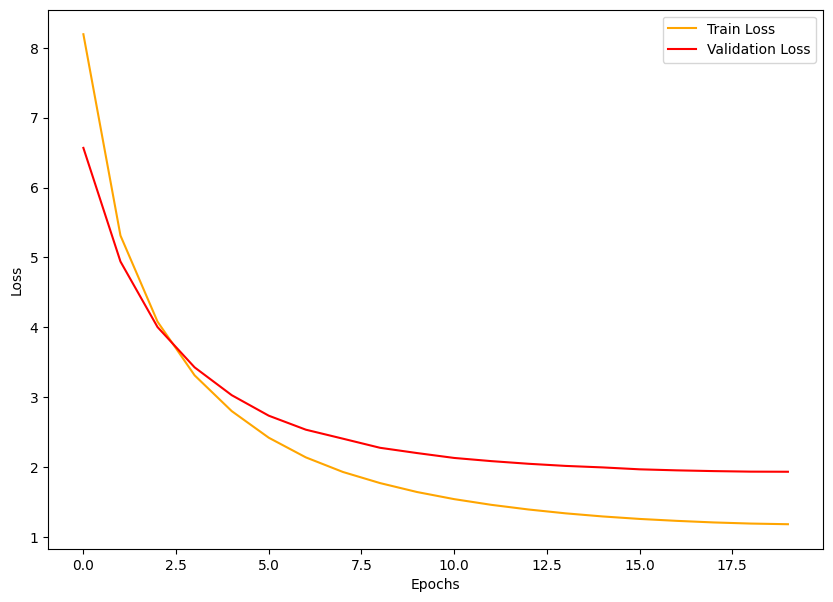

In [18]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='Train Loss'
)
plt.plot(
    val_loss, color='red', linestyle='-', 
    label='Validation Loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [27]:
transformer.load_state_dict(torch.load('./Saves_MT/tranformer_pt_20.pth.tar')['state_dict'])

<All keys matched successfully>

In [13]:
def test(model, criterion, test_dataloader):
    model.eval()
    losses = 0
    for src, tgt in tqdm(test_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()


    return losses / len(list(test_dataloader))

test_dataloader = SmartDataLoader(eng_vocab, ger_vocab, BATCH_SIZE, eng_vocab.max_length, ger_vocab.max_length, eng_test, ger_test)
test_loss = test(transformer, criterion, test_dataloader)

100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


In [30]:
test_sent = 'Cat is chasing a dog' 
# German = "Katze jagt einen Hund"
print(translate(transformer, test_sent))

katze ist eine hund


With limited training and vocabulary, the model can only perform so well. The model can further be improved by using larger dataset and training for more epoch. Pretrained embeddings can also be used.